train120m-180m, train:valid 90:10, countuniq

In [1]:
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import gc
from contextlib import contextmanager
import matplotlib.pyplot as plt

In [2]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

def df_add_counts(df, cols):
    arr_slice = df[cols].values
    unq, unqtags, counts = np.unique(np.ravel_multi_index(arr_slice.T, arr_slice.max(axis=0) + 1),
                                     return_inverse=True, return_counts=True)
    df["_".join(cols)+'_count'] = counts[unqtags]
    gc.collect()
    
def make_count_features(df):
    with timer("add count features"):
        df['click_time']= pd.to_datetime(df['click_time'])
        dt= df['click_time'].dt
#         df['day'] = dt.day.astype('uint8')
        df['hour'] = dt.hour.astype('uint8')
#         df['minute'] = dt.minute.astype('uint8')
#         df['second'] = dt.second.astype('uint8')#secondを追加

        del(dt)
        
        df_add_counts(df, ['ip'])
#         df_add_counts(df, ['ip','day','hour','minute'])
        df_add_counts(df, ['os','device'])
        df_add_counts(df, ['os','app','channel'])
        
        df_add_counts(df, ['ip', 'hour'])
        df_add_counts(df, ['ip', 'app'])
        df_add_counts(df, ['ip', 'app', 'os'])
        df_add_counts(df, ['ip', 'device'])
        df_add_counts(df, ['app', 'channel'])

def do_countuniq( df, group_cols, counted, agg_type='uint32', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_countuniq'.format(('_'.join(group_cols)),(counted))  
    if show_agg:
        print( "\nCounting unqiue ", counted, " by ", group_cols ,  '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
#     predictors.append(agg_name)
#     print('predictors',predictors)
    gc.collect()
    return( df )

def make_countuniq_features(df):
    with timer("add countuniq features"):
        df = do_countuniq( df, ['ip'], 'channel' ); gc.collect()
        df = do_countuniq( df, ['ip', 'device', 'os'], 'app'); gc.collect()
        df = do_countuniq( df, ['ip'], 'hour' ); gc.collect()
        df = do_countuniq( df, ['ip'], 'app'); gc.collect()
        df = do_countuniq( df, ['ip', 'app'], 'os'); gc.collect()
        df = do_countuniq( df, ['ip'], 'device'); gc.collect()
        df = do_countuniq( df, ['app'], 'channel'); gc.collect()
        return(df)

def make_next_click_feature(df):
    with timer("Adding next click times"):
        D= 2**26
        df['category'] = (df['ip'].astype(str) + "_" + df['app'].astype(str) + "_" + df['device'].astype(str) \
                         + "_" + df['os'].astype(str)).apply(hash) % D
        click_buffer= np.full(D, 3000000000, dtype=np.uint32)
        df['epochtime']= df['click_time'].astype(np.int64) // 10 ** 9
        next_clicks= []
        for category, time in zip(reversed(df['category'].values), reversed(df['epochtime'].values)):
            next_clicks.append(click_buffer[category]-time)
            click_buffer[category]= time
        del(click_buffer)
        df['next_click']= list(reversed(next_clicks))
        gc.collect()
        
path = '~/talkingdata/input/'

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

columns = ['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

In [3]:
with timer("load training data"):
    train_df = pd.read_csv(path+"train.csv",skiprows=range(1,122071518), usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'], dtype=dtypes)

with timer("load test data"):
    testsup_df = pd.read_csv(path+"test_supplement.csv", dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

[load training data] done in 122 s
[load test data] done in 45 s


In [4]:
num_train = train_df.shape[0]

y = train_df.is_attributed.values
gc.collect()

# sub = pd.DataFrame()
# sub['click_id'] = test_df.click_id.values

common_column = ['ip','app','device','os','channel','click_time']
concat_df = pd.concat([train_df[common_column],testsup_df[common_column]])

del train_df, testsup_df
gc.collect()

64

In [5]:
make_count_features(concat_df)

[add count features] done in 462 s
[Adding next click times] done in 829 s


In [ ]:
make_next_click_feature(df)

In [7]:
concat_df = make_countuniq_features(concat_df)

gc.collect()


Counting unqiue  channel  by  ['ip'] ... and saved in ip_by_channel_countuniq

Counting unqiue  app  by  ['ip', 'device', 'os'] ... and saved in ip_device_os_by_app_countuniq

Counting unqiue  hour  by  ['ip'] ... and saved in ip_by_hour_countuniq

Counting unqiue  app  by  ['ip'] ... and saved in ip_by_app_countuniq

Counting unqiue  os  by  ['ip', 'app'] ... and saved in ip_app_by_os_countuniq

Counting unqiue  device  by  ['ip'] ... and saved in ip_by_device_countuniq

Counting unqiue  channel  by  ['app'] ... and saved in app_by_channel_countuniq
[add countuniq features] done in 1045 s


47

In [8]:
concat_df.head()

,ip,app,device,os,channel,click_time,hour,ip_count,os_device_count,os_app_channel_count,...,category,epochtime,next_click,ip_by_channel_countuniq,ip_device_os_by_app_countuniq,ip_by_hour_countuniq,ip_by_app_countuniq,ip_app_by_os_countuniq,ip_by_device_countuniq,app_by_channel_countuniq
0,62766,7,3543,748,101,2017-11-08 16:00:00,16,3103,1,1,...,17297157,1510156800,1489843200,98,1,24,43,10,7,3
1,108229,15,1,19,245,2017-11-08 16:00:00,16,7399,27561927,289727,...,64159849,1510156800,200,102,32,24,46,44,12,27
2,73487,12,2,22,326,2017-11-08 16:00:00,16,486915,158918,14319,...,36302508,1510156800,181,141,28,24,173,125,148,32
3,238206,14,1,19,379,2017-11-08 16:00:00,16,1,27561927,319932,...,24064575,1510156800,47520,1,1,1,1,1,1,38
4,27482,26,1,32,121,2017-11-08 16:00:00,16,3958,1006744,9873,...,34692003,1510156800,927,94,17,24,47,17,12,5


In [9]:
train_df = concat_df.iloc[:num_train]
testsup_df = concat_df.iloc[num_train:]

del concat_df
gc.collect()

89

In [11]:
# import pickle
# with open('train_after.csv.pkl','wb') as f:
#   pickle.dump(train_df, f, protocol=2)

# with open('testsup_after.csv.pkl','wb') as f:
#   pickle.dump(testsup_df, f, protocol=2)

# with open('test_after.csv.pkl','wb') as f:
#   pickle.dump(test_df, f, protocol=2)

OverflowError: cannot serialize a string larger than 4GiB

In [12]:
x_train, x_val, y_train, y_val = train_test_split(train_df, y, train_size=0.9, shuffle=False)

del train_df, y

/home/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [13]:
evals_results = {}
num_boost_round = 250
early_stopping_rounds = 30

lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 0,  # L2 regularization term on weights
    'nthread': 12,
    'verbose': 0,
    'metric':'auc',     
 
    'learning_rate': 0.15,
    'num_leaves': 7,  # 2^max_depth - 1
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':99
}
# metrics = 'auc'
# lgb_params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'metric': metrics,
#     'learning_rate': .1,
#     'num_leaves': 7,
#     'max_depth': 4,
#     'min_child_samples': 100,
#     'max_bin': 100,
#     'subsample': 0.7,
#     'subsample_freq': 1,
#     'colsample_bytree': 0.7,
#     'min_child_weight': 0,
#     'min_split_gain': 0,
#     'nthread': 4,
#     'verbose': 1,
#     'scale_pos_weight': 99.7
#     #'scale_pos_weight': 400
# }

In [16]:
target = "is_attributed"
categorical = ['app','os','channel','device','hour']
predictors = list(set(x_train.columns)-set([target])-set(['click_time','category','epochtime','ip']))
print(predictors)

print("preparing validation datasets")

xgtrain = lgb.Dataset(x_train[predictors].values,
                      label=y_train,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

del x_train
del y_train
gc.collect()

xgvalid = lgb.Dataset(x_val[predictors].values,
                      label=y_val,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

del x_val
del y_val
gc.collect()

['ip_by_device_countuniq', 'ip_by_hour_countuniq', 'os_app_channel_count', 'channel', 'ip_by_channel_countuniq', 'ip_app_by_os_countuniq', 'hour', 'ip_hour_count', 'ip_count', 'app_channel_count', 'device', 'os_device_count', 'ip_app_count', 'ip_app_os_count', 'app', 'os', 'ip_device_os_by_app_countuniq', 'next_click', 'ip_device_count', 'app_by_channel_countuniq', 'ip_by_app_countuniq']
preparing validation datasets


24

In [17]:
# gc.collect()
booster = lgb.train(
     lgb_params, 
     xgtrain,
     valid_sets=[xgvalid],
     valid_names=['valid'],
     evals_result=evals_results, 
     num_boost_round=num_boost_round,
     early_stopping_rounds=early_stopping_rounds,
     verbose_eval=1
)

del xgvalid
del xgtrain
gc.collect()

/home/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid's auc: 0.946064
Training until validation scores don't improve for 30 rounds.
[2]	valid's auc: 0.966295
[3]	valid's auc: 0.967151
[4]	valid's auc: 0.967719
[5]	valid's auc: 0.969444
[6]	valid's auc: 0.969776
[7]	valid's auc: 0.970232
[8]	valid's auc: 0.970482
[9]	valid's auc: 0.970741
[10]	valid's auc: 0.970831
[11]	valid's auc: 0.971199
[12]	valid's auc: 0.971256
[13]	valid's auc: 0.972113
[14]	valid's auc: 0.97218
[15]	valid's auc: 0.972616
[16]	valid's auc: 0.97269
[17]	valid's auc: 0.973174
[18]	valid's auc: 0.973284
[19]	valid's auc: 0.973751
[20]	valid's auc: 0.974998
[21]	valid's auc: 0.976039
[22]	valid's auc: 0.97636
[23]	valid's auc: 0.976717
[24]	valid's auc: 0.976881
[25]	valid's auc: 0.9775
[26]	valid's auc: 0.977263
[27]	valid's auc: 0.977712
[28]	valid's auc: 0.978057
[29]	valid's auc: 0.978154
[30]	valid's auc: 0.978476
[31]	valid's auc: 0.978675
[32]	valid's auc: 0.979078
[33]	valid's auc: 0.97946
[34]	valid's auc: 0.979684
[35]	valid's auc: 0.979924
[36]	val

32

In [18]:
n_estimators = booster.best_iteration
metrics = 'auc'

print('\nModel Info:')
print('n_estimators:', n_estimators)
print(metrics+':', evals_results['valid'][metrics][n_estimators-1])


Model Info:
n_estimators: 247
auc: 0.9875199092127325


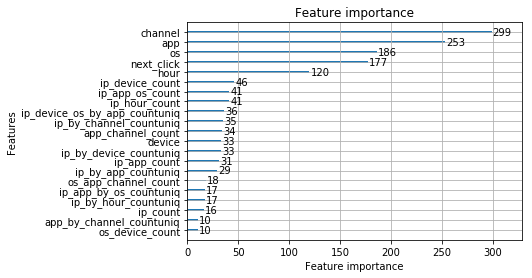

In [19]:
ax = lgb.plot_importance(booster, max_num_features=100)
plt.show()

In [20]:
plt.savefig('0504-1imp.png', dpi=600, bbox_inches='tight')

In [21]:
gc.collect()

150

In [22]:
with timer("load test data"):
    test_df = pd.read_csv(path+"test.csv", dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

[load test data] done in 15 s


In [23]:
test_df['click_time']= pd.to_datetime(test_df['click_time'])
testsup_df['click_time']= pd.to_datetime(testsup_df['click_time'])

In [24]:
# preditions=booster.predict(test_df[predictors].values)

print("Predicting the submission data...")

testsup_df['is_attributed'] = booster.predict(testsup_df[predictors], num_iteration=booster.best_iteration)

print('projecting prediction onto test')

join_cols = ['ip', 'app', 'device', 'os', 'channel', 'click_time']
all_cols = join_cols + ['is_attributed']

Predicting the submission data...
projecting prediction onto test


In [25]:
test_df = test_df.merge(testsup_df[all_cols], how='left', on=join_cols)

test_df = test_df.drop_duplicates(subset=['click_id'])

In [26]:
test_df.head()

,click_id,ip,app,device,os,channel,click_time,is_attributed
0,0,5744,9,1,3,107,2017-11-10 04:00:00,0.063350
1,1,119901,9,1,3,466,2017-11-10 04:00:00,0.010723
2,2,72287,21,1,19,128,2017-11-10 04:00:00,0.001795
3,3,78477,15,1,13,111,2017-11-10 04:00:00,0.026893
4,4,123080,12,1,13,328,2017-11-10 04:00:00,0.004572


In [27]:
test_df.count()

click_id         18790469
ip               18790469
app              18790469
device           18790469
os               18790469
channel          18790469
click_time       18790469
is_attributed    18790469
dtype: int64

In [28]:
print("Writing the submission data into a csv file...")

test_df[['click_id', 'is_attributed']].to_csv('0504-1.csv', index=False)

print("All done...")

Writing the submission data into a csv file...
All done...


In [2]:
testsup_df.head()

NameError: name 'testsup_df' is not defined